In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentencepiece einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00


In [4]:
import torch
from transformers import LlamaTokenizer, AutoModelForVision2Seq, BlipImageProcessor
from PIL import Image
import requests

In [5]:
model = AutoModelForVision2Seq.from_pretrained("stabilityai/japanese-instructblip-alpha", trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/stabilityai/japanese-instructblip-alpha:
- configuration_japanese_stablelm_alpha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/stabilityai/japanese-instructblip-alpha:
- configuration_japanese_instructblip_alpha.py
- configuration_japanese_stablelm_alpha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/stabilityai/japanese-instructblip-alpha:
- modeling_japanese_stablelm_alpha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/stabilityai/japanese-instructblip-alpha:
- modeling_japanese_instructblip_alpha.py
- modeling_japanese_stablelm_alpha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
processor = BlipImageProcessor.from_pretrained("stabilityai/japanese-instructblip-alpha", device=device)

### Signateのデータをダウンロード

In [8]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4733d8a6bcf6c013b65c75c944ce35a078dabed2c11e2cbd686f1aad0f755086
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [9]:
!mkdir /root/.signate/

In [10]:
!cp /content/drive/MyDrive/MyStudy/MySIGNATE/signate.json /root/.signate/

In [11]:
!signate download --competition-id=1106

dataset_definition.md

train.csv

sample_submit.csv

test.zip

train.zip


Download completed.


In [12]:
%%capture
!unzip train.zip

In [13]:
%%capture
!unzip test.zip

### 後続の小さいNNを学習

In [14]:
import os
import os.path as osp

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

In [15]:
TRAIN_DATA_SIZE = int(2176 * 0.8 * 3) # データ数を3倍にする

class TrainImgDataset(Dataset):
    def __init__(self, img_dir, img_paths, labels, transform=None):
        self.img_dir = img_dir
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return TRAIN_DATA_SIZE

    def __getitem__(self, idx):
        img_path = osp.join(self.img_dir, self.img_paths[idx % len(self.img_paths)])
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        image = processor(images=img, return_tensors='pt')

        return image.pixel_values[0], self.labels[idx % len(self.img_paths)]

In [16]:
class ImgDataset(Dataset):
    def __init__(self, img_dir, img_paths, labels, transform=None):
        self.img_dir = img_dir
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = osp.join(self.img_dir, self.img_paths[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        image = processor(images=img, return_tensors='pt')

        return image.pixel_values[0], self.labels[idx]

In [17]:
from torchvision import transforms

trans = transforms.Compose([
    # transforms.ToTensor(),
    transforms.AutoAugment(),
    transforms.RandomApply(
        nn.ModuleList([
            # transforms.ColorJitter(),
            transforms.GaussianBlur(kernel_size=11),
        ]),
        p=0.2
    ),
    transforms.RandomRotation((-180, 180)), # 回転を追加
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [18]:
train_img_dir = "./train"
train_df = pd.read_csv("train.csv")

train, valid = train_test_split(train_df, test_size=0.2, stratify=train_df["label"], random_state=42, shuffle=True)
train_dataset = TrainImgDataset(img_dir="./train", img_paths=train["image_name"].values, labels=train["label"].values, transform=trans)
valid_dataset = ImgDataset(img_dir="./train", img_paths=valid["image_name"].values, labels=valid["label"].values)

In [19]:
batch_size = 32

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# blipのpooler_outputを使用する場合

class wrapperModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.vision_model = model.vision_model
        self.hidden_1 = nn.Linear(1408, 512)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout1d(p=0.3)
        self.hidden_2 = nn.Linear(512, 256)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout1d(p=0.3)
        self.hidden_3 = nn.Linear(256, 128)
        self.relu_3 = nn.ReLU()
        self.dropout_3 = nn.Dropout1d(p=0.3)
        self.hidden_4 = nn.Linear(128, 64)
        self.relu_4 = nn.ReLU()
        self.dropout_4 = nn.Dropout1d(p=0.3)
        self.classifier_head = nn.Linear(64, 2)

    def forward(self, x):
        out = self.vision_model(x).pooler_output.unsqueeze(1)
        out = self.hidden_1(out)
        out = self.relu_1(out)
        out = self.dropout_1(out)
        out = self.hidden_2(out)
        out = self.relu_2(out)
        out = self.dropout_2(out)
        out = self.hidden_3(out)
        out = self.relu_3(out)
        out = self.dropout_3(out)
        out = self.hidden_4(out)
        out = self.relu_4(out)
        out = self.dropout_4(out)
        y = self.classifier_head(out)

        return y

In [44]:
# import io
# img = Image.open('./train/0000.png').convert('RGB')
# image = processor(images=img, return_tensors='pt')

# test_model = model.vision_model
# with torch.no_grad():
#     outputs = test_model(image.pixel_values)
#     print(outputs.last_hidden_state.size())

# avg = nn.AvgPool1d(kernel_size=1408)
# avg(outputs.last_hidden_state).squeeze(dim=2).shape

torch.Size([1, 257, 1408])


torch.Size([1, 257])

In [39]:
# # blipのhiddne outputをすべて使う場合(pooling)
# class wrapperModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.vision_model = model.vision_model
#         self.hidden_1 = nn.Linear(1408, 512)
#         self.relu_1 = nn.ReLU()
#         self.dropout_1 = nn.Dropout1d(p=0.3)
#         self.hidden_2 = nn.Linear(512, 64)
#         self.relu_2 = nn.ReLU()
#         self.dropout_2 = nn.Dropout1d(p=0.3)
#         self.classifier_head = nn.Linear(64, 2)

#     def forward(self, x):
#         out = self.vision_model(x).last_hidden_state # out.shape = (batch, seq, vec)
#         out = torch.mean(out, dim=1) # out.shape = (batch, vec)
#         out = self.hidden_1(out)
#         out = self.relu_1(out)
#         out = self.dropout_1(out)
#         out = self.hidden_2(out)
#         out = self.relu_2(out)
#         out = self.dropout_2(out)
#         y = self.classifier_head(out)

#         return y

In [21]:
# # blipのhiddne outputをすべて使う場合(conv)
# class wrapperModel(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.vision_model = model.vision_model
#         self.conv_1 = nn.Conv1d(in_channels=257, out_channels=257, kernel_size=3, stride=2)
#         # self.hidden_1 = nn.Linear(257, 128)
#         self.relu_1 = nn.ReLU()
#         self.dropout_1 = nn.Dropout1d(p=0.3)
#         self.conv_2 = nn.Conv1d(in_channels=257, out_channels=257, kernel_size=3, stride=2)
#         # self.hidden_2 = nn.Linear(128, 64)
#         self.relu_2 = nn.ReLU()
#         self.dropout_2 = nn.Dropout1d(p=0.3)
#         self.conv_3 = nn.Conv1d(in_channels=257, out_channels=257, kernel_size=3, stride=2)
#         # self.hidden_3 = nn.Linear(128, 64)
#         self.relu_3 = nn.ReLU()
#         self.dropout_3 = nn.Dropout1d(p=0.3)
#         # self.classifier_head = nn.Linear(64, 2)
#         self.classifier_head = nn.Linear(257, 2)

#     def forward(self, x):
#         out = self.vision_model(x).last_hidden_state
#         out = self.conv_1(out)
#         # out = self.hidden_1(out)
#         out = self.relu_1(out)
#         out = self.dropout_1(out)
#         out = self.conv_2(out)
#         # out = self.hidden_2(out)
#         out = self.relu_2(out)
#         out = self.dropout_2(out)
#         out = self.conv_3(out)
#         # out = self.hidden_2(out)
#         out = self.relu_3(out)
#         out = self.dropout_3(out)
#         out = torch.mean(out, dim=2)
#         y = self.classifier_head(out)

#         return y

In [22]:
wrapper_model = wrapperModel()
wrapper_model.to(device)

wrapperModel(
  (vision_model): InstructBlipVisionModel(
    (embeddings): InstructBlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): InstructBlipEncoder(
      (layers): ModuleList(
        (0-38): 39 x InstructBlipEncoderLayer(
          (self_attn): InstructBlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): InstructBlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (pos

In [23]:
for name, param in wrapper_model.named_parameters():
    if "vision_model" in name:
        param.requires_grad = False

In [24]:
EPOCH_NUM = 50
optimizer = Adam(wrapper_model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH_NUM, eta_min=1e-6)
criterion = nn.CrossEntropyLoss()

In [25]:
writer = SummaryWriter(log_dir="./log_full_train")

In [26]:
torch.cuda.empty_cache()

In [27]:
import numpy as np

prev_loss = float("inf")
best_loss = float("inf")
pbar = tqdm(range(EPOCH_NUM))
l2_coef = 5e-4
for epoch in pbar:

    epoch_loss_arr = np.array([])

    wrapper_model.train()
    for iter_num, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        with torch.autocast("cuda"):
            pred_y = wrapper_model(X)

            l2_loss = 0.0
            for name, param in wrapper_model.named_parameters():
                if 'classifier_head' in name:
                    l2_loss += torch.norm(param)**2

            ce_loss = criterion(pred_y, y)
            loss = ce_loss + l2_coef*l2_loss
            loss_tmp = ce_loss.to('cpu').detach().numpy().copy()

        loss.backward()
        optimizer.step()
        epoch_loss_arr = np.append(epoch_loss_arr, loss_tmp)
        pbar.set_description(f"Epoch/Iter {epoch}/{iter_num}: loss{loss.item():.4f} / {prev_loss:.4f}")
        writer.add_scalar("train/loss", loss.item(), epoch*len(train_dataloader)+iter_num)
    scheduler.step()
    ave_train_loss = np.average(epoch_loss_arr)

    val_loss = 0
    wrapper_model.eval()
    for iter_num, (X, y) in enumerate(valid_dataloader):
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad(), torch.autocast("cuda"):
            pred_y = wrapper_model(X)
            loss = criterion(pred_y, y)
            val_loss += loss.item()

        writer.add_scalar("train/loss", loss.item(), epoch*len(valid_dataloader)+iter_num)

    prev_loss = val_loss / len(valid_dataloader)
    if best_loss > prev_loss:
        best_loss = prev_loss
        torch.save(wrapper_model.state_dict(), "/content/drive/MyDrive/MyStudy/MySIGNATE/package-classification-comp/models/blip-pooler-output_and_NN-with-4MLP_TRAIN-DATA-SIZE-x3/model_parameters.pt")
    print(f'train/val: {ave_train_loss:.5f}/{prev_loss:.5f}')

Epoch/Iter 0/163: loss0.6020 / inf:   2%|▏         | 1/50 [03:47<3:05:46, 227.48s/it]

train/val: 0.69079/0.68852


Epoch/Iter 1/163: loss0.6798 / 0.6885:   4%|▍         | 2/50 [07:14<2:52:15, 215.32s/it]

train/val: 0.69042/0.68938


Epoch/Iter 2/80: loss0.6943 / 0.6894:   4%|▍         | 2/50 [08:49<3:31:52, 264.85s/it]


KeyboardInterrupt: ignored

In [ ]:
# %load_ext tensorboard

In [ ]:
# !tensorboard --logdir /content/log_full_train

In [32]:
wrapper_model.load_state_dict(torch.load('/content/drive/MyDrive/MyStudy/MySIGNATE/package-classification-comp/models/blip-poolingOutput_and_NN-with-hiddenLayer-512-64_TRAIN-DATA-SIZE-x3/model_parameters.pt'))

<All keys matched successfully>

In [50]:
preds = torch.empty((len(valid_dataset), 2))
wrapper_model.eval()
for iter_num, (X, y) in enumerate(valid_dataloader):
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(), torch.autocast("cuda"):
        pred_y = wrapper_model(X).softmax(dim=1)
        preds[iter_num*batch_size:(iter_num+1)*batch_size] = pred_y.detach()

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [52]:
fpr, tpr, thresholds = roc_curve(valid["label"], preds[:, 1].numpy())
roc_auc = roc_auc_score(valid["label"], preds[:, 1].numpy())

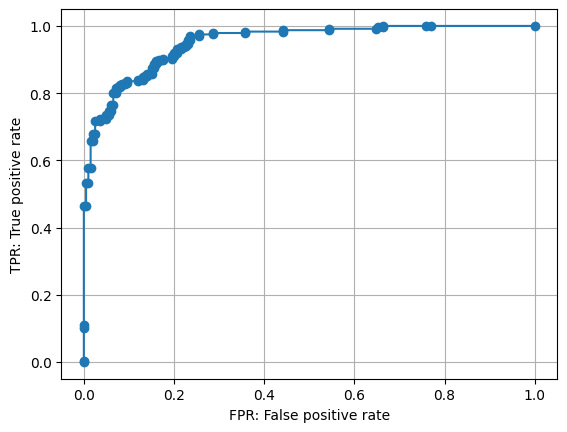

In [53]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [54]:
roc_auc

0.9506710769035049

In [55]:
from glob import glob
import numpy as np
test_img_paths = sorted(glob("./test/*.png"))
test_dataset = ImgDataset(img_dir="./", img_paths=test_img_paths, labels=np.zeros(len(test_img_paths)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
preds = torch.empty((len(test_dataset), 2))
wrapper_model.eval()
for iter_num, (X, y) in enumerate(test_dataloader):
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(), torch.autocast("cuda"):
        pred_y = wrapper_model(X).softmax(dim=1)
        preds[iter_num*batch_size:(iter_num+1)*batch_size] = pred_y.detach()

In [57]:
test_df = pd.DataFrame()
test_df["filenames"] = list(map(lambda x: x.split("/")[-1], test_img_paths))
test_df["pred"] = preds[:, 1].numpy()

In [60]:
test_df.to_csv("/content/drive/MyDrive/MyStudy/MySIGNATE/package-classification-comp/work/blip-poolingOutput_and_NN-with-hiddenLayer-512-64_TRAIN-DATA-SIZE-x3.csv", index=False, header=False)

In [59]:
test_df

,filenames,pred
0,2176.png,0.004000
1,2177.png,0.908780
2,2178.png,0.161320
3,2179.png,0.998299
4,2180.png,0.010714
...,...,...
2175,4351.png,0.000957
2176,4352.png,0.006693
2177,4353.png,0.566607
2178,4354.png,0.847779
